In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from sklearn import linear_model, cross_validation
from sklearn import grid_search
import pylab as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
pd.set_option("precision", 2)
execfile("toolbox.py")

In [3]:
data = pd.read_csv("data_source/frankeinstein.csv", index_col=['code', 'year'])
print "Number of countries : ", len(data.index.levels[0])
original_variables = data.keys()
print data.info()

Number of countries :  127
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2861 entries, (AFG, 2007.0) to (ZMB, 2010.0)
Data columns (total 11 columns):
GDP_growth_WB                 2861 non-null float64
openness_WB                   2861 non-null float64
investments                   2861 non-null float64
years_schooling               2861 non-null float64
savings                       2861 non-null float64
gini                          2861 non-null float64
price_level_investment_PWT    2861 non-null float64
gov_consumption_WB            2861 non-null float64
inflation_WB                  2861 non-null float64
fertility_WB                  2861 non-null float64
GDP_PC                        2861 non-null float64
dtypes: float64(11)
memory usage: 268.2+ KB
None


In [4]:
continent_data = pd.read_csv("data_source/country_continent_code.csv",
                             index_col=['ISO 3166-1 alpha-3'], keep_default_na=False, na_values=['chaineimprobable'])

data["africa"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'AF')).values
data["latin_am"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'SA')).values
data["asia"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'AS')).values
data["oceania"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'OC')).values
data["europe"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'EU')).values
data["north_am"] = data.reset_index()['code'].apply(
    lambda x: int(continent_data.loc[x]['continent'] == 'NA')).values

In [5]:
for var in original_variables:
    data['past_' +  var] = rolling_mean(data, var, 10, 5, how='past')
data = data.dropna(how='any')

In [6]:
for var in original_variables:
    data['var_' +  var] = growth(data, var, how='past')

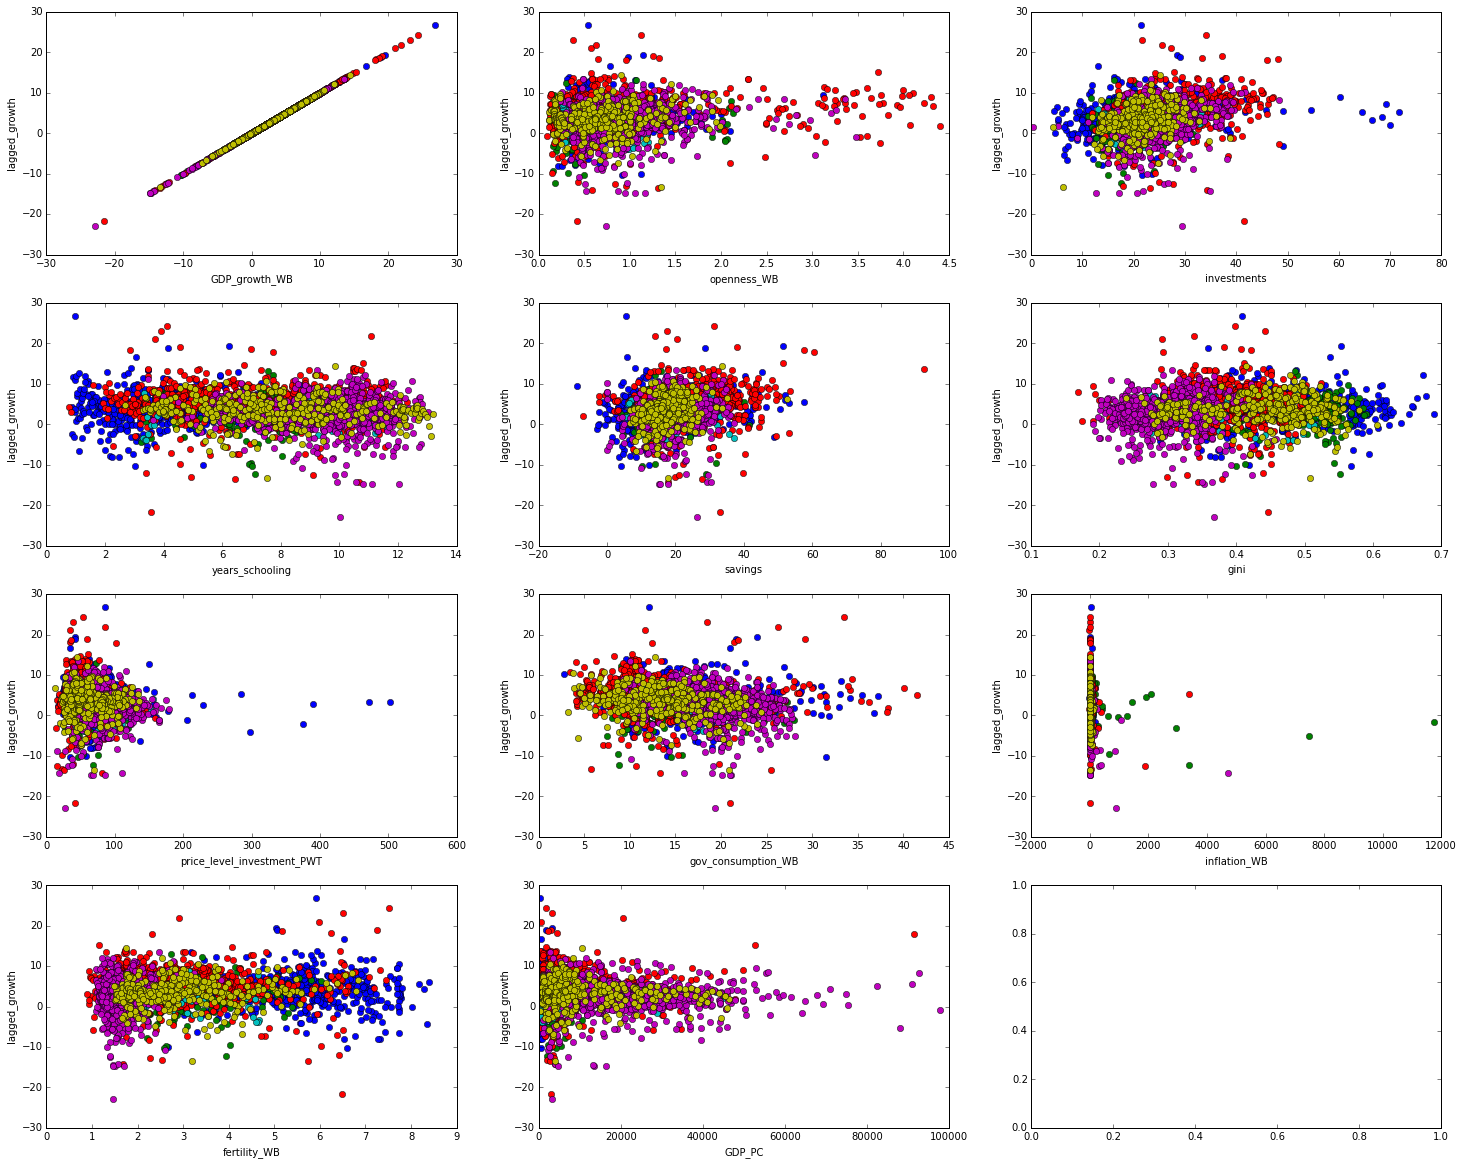

In [9]:
nbr_cols = 3
variables = original_variables
f, axarr = plt.subplots((len(original_variables) / nbr_cols)+1, nbr_cols, figsize=(25,20))
for n, var in enumerate(original_variables):
    i,j = n/nbr_cols, n%nbr_cols
    for cont in ['africa', 'latin_am', 'asia', 'oceania', 'europe', 'north_am']:
        sel_data = data[data[cont] == 1]
        axarr[i, j].plot(sel_data[var], sel_data['GDP_growth_WB'], 'o')
        axarr[i, j].set_xlabel(var)
        axarr[i, j].set_ylabel('lagged_growth')

In [32]:
print data['GDP_growth_WB'].values.shape
print data['past_savings'].values.shape

(2357,)
(2357,)


[ 4.02407545]


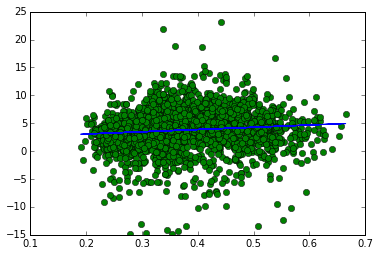

In [130]:
X = data[data['var_savings'].apply(lambda x: abs(x) < 15)][['gini']]
Y = data[data['var_savings'].apply(lambda x: abs(x) < 15)]['GDP_growth_WB']

clf = linear_model.LinearRegression()
clf.fit(X, Y)

plt.plot(X, Y, 'go')
plt.plot(X, clf.predict(X), 'b')

print clf.coef_

Number of countries 100
Mean of coefficients -6.03014955685
Standard deviation 122.936342117
Skewness -0.412037575329


,coef
country,
SWZ,-6.8e+02


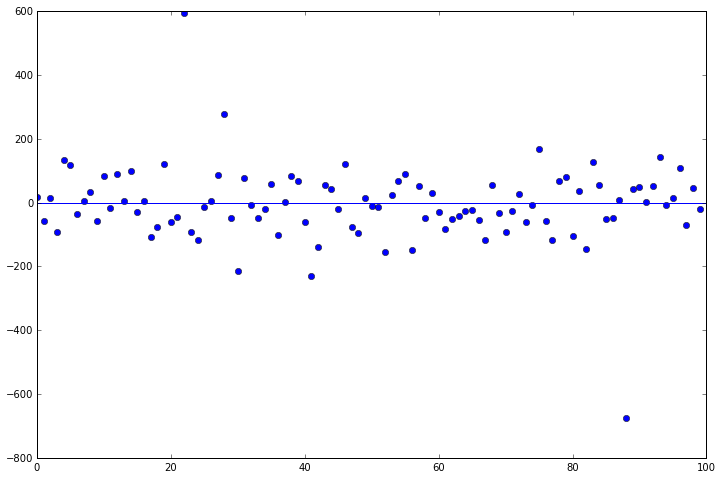

In [131]:
results = pd.DataFrame(columns=["country", "coef"])
results.set_index("country", inplace=True)
for country in data.index.levels[0]:
    X = data.loc[country][['gini']]
    Y = data.loc[country]['savings']
    if len(X) >= 10:
        clf = linear_model.LinearRegression()
        clf.fit(X, Y)
        results.loc[country, "coef"] = clf.coef_[0]
plt.figure(figsize=(12,8))        
plt.plot(results, 'o')
plt.axhline()

print "Number of countries", len(results)
print "Mean of coefficients", results.mean().values[0]
print "Standard deviation", results.std().values[0]
print "Skewness", results.skew().values[0]
results[results['coef'] == results['coef'].min()]

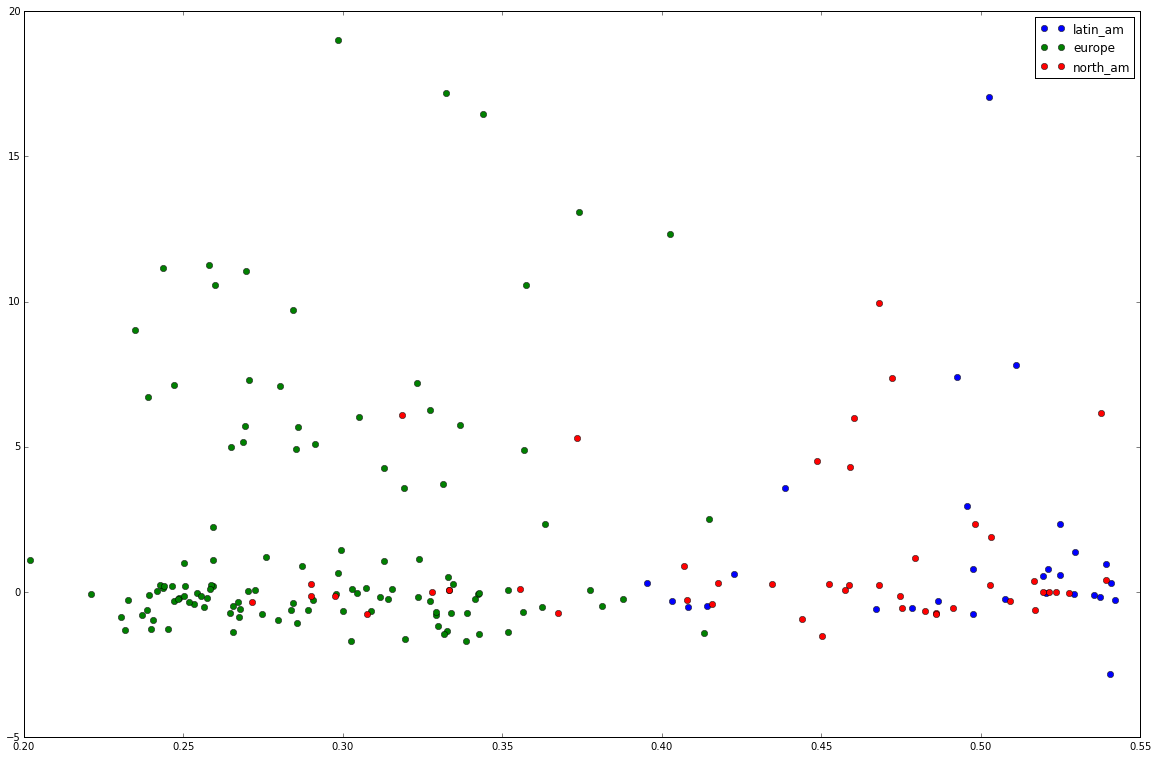

In [110]:
plt.figure(figsize=(20, 13))
#for cont in ['africa', 'latin_am', 'asia', 'oceania', 'europe', 'north_am']:
for cont in ['latin_am', 'europe', 'north_am']:
    sel_data = resample(data[data[cont] == 1], 10)
    plt.plot(sel_data['past_gini'], sel_data['var_GDP_growth_WB'], 'o', label=cont)
plt.legend()